In [1]:
import matplotlib.pyplot as plt
from icecream import ic
import time

import torch
from torch import nn, Tensor
from torch.nn import functional as F

from src.model import get_magnet_model
from src.preprocess_ops import PreProOps
from src.music_bench import (
    MAX_SEC,
    shuffle_preserve_order,
    QCODING_LEN,
)
from src.train import PreProDataset, MagnetTrainer
from src.utils.lr_scheduler import CosineDecayWithWarmup
from src.music_bench import AUDIO_TXT_PATH, ioPathTextDs

torch.backends.cudnn.deterministic = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

from src.train import tonfig
DEVICE = torch.device("cuda")

# Test Model

## Forward pass

In [2]:
ctx = (
        torch.autocast(
                device_type="cuda" if "cuda" in DEVICE.type else "cpu",
                dtype={"bfloat16": torch.bfloat16,
                       "float16" : torch.float16}[tonfig.dtype]
        )
    )

In [3]:
preprocess_ops = PreProOps(
    max_sec=QCODING_LEN,
    print_info=True,
    device=DEVICE.type,
    compile=False,
    autocast=ctx
)

/home/vvy/Desktop/repos/MAGNeT/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [10]:
dataset = ioPathTextDs(
    save_path=AUDIO_TXT_PATH,
    batch_size=2,
    split_float=0.9,
    return_ds=True
)
x_train, y_train = dataset["train"]
train_iterator = iter(PreProDataset(
    wav_paths=x_train[100:101],
    texts=y_train[100:101],
    audio_pad_id=1024,
    device=DEVICE.type,
    qcoding_len=QCODING_LEN,
    preprocess_ops=preprocess_ops,
).iter_batches())
next(train_iterator)

Dataset is preprocessed.


({'qcode': tensor([[[ 696,  679, 1008,  ..., 1024, 1024, 1024],
           [ 923,  419,  866,  ..., 1024, 1024, 1024],
           [ 873,  949,  181,  ..., 1024, 1024, 1024],
           [ 330,  413,  639,  ..., 1024, 1024, 1024]],
  
          [[ 850,  642,  982,  ...,  239,  986,  226],
           [ 214,  993,  552,  ...,  827,  191,  858],
           [ 159,  159,   10,  ...,  405,  204,  318],
           [ 725,  567,  818,  ...,  257,  400,  819]]], device='cuda:0'),
  'mask': tensor([[[ True,  True,  True,  ..., False, False, False],
           [ True,  True,  True,  ..., False, False, False],
           [ True,  True,  True,  ..., False, False, False],
           [ True,  True,  True,  ..., False, False, False]],
  
          [[ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True]]], device='cuda:0')},
 ['Thi

In [11]:
magnet_model = get_magnet_model().to(DEVICE)

# Test Training:

# Try Overfitting lil batch

In [12]:
dataset = ioPathTextDs(
    save_path=AUDIO_TXT_PATH,
    batch_size=2,
    split_float=0.9,
    return_ds=True
)
x_train, y_train = dataset["train"]
train_iterator = iter(PreProDataset(
    wav_paths=x_train[100:101],
    texts=y_train[100:101],
    audio_pad_id=1024,
    device=DEVICE.type,
    qcoding_len=QCODING_LEN,
    preprocess_ops=preprocess_ops,
).iter_batches())
next(train_iterator)

Dataset is preprocessed.


({'qcode': tensor([[[ 696,  679, 1008,  ..., 1024, 1024, 1024],
           [ 923,  419,  866,  ..., 1024, 1024, 1024],
           [ 873,  949,  181,  ..., 1024, 1024, 1024],
           [ 330,  413,  639,  ..., 1024, 1024, 1024]],
  
          [[ 850,  642,  982,  ...,  239,  986,  226],
           [ 214,  993,  552,  ...,  827,  191,  858],
           [ 159,  159,   10,  ...,  405,  204,  318],
           [ 725,  567,  818,  ...,  257,  400,  819]]], device='cuda:0'),
  'mask': tensor([[[ True,  True,  True,  ..., False, False, False],
           [ True,  True,  True,  ..., False, False, False],
           [ True,  True,  True,  ..., False, False, False],
           [ True,  True,  True,  ..., False, False, False]],
  
          [[ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True]]], device='cuda:0')},
 ['Thi

In [13]:
print(sum(p.numel() for p in magnet_model.parameters() if p.requires_grad)/1e6, "Million Parameters")

37.833728 Million Parameters


In [14]:
magnet_trainer = MagnetTrainer(
    magnet_model=magnet_model,
    preprocess_ops=preprocess_ops,
    config=tonfig
)

get_lr = CosineDecayWithWarmup(
    warmup_steps=tonfig.warmup_steps,
    max_learning_rate=tonfig.max_learning_rate,
    decay_steps=tonfig.decay_steps,
    min_learning_rate=tonfig.min_learning_rate
)

scaler = torch.cuda.amp.GradScaler(enabled=(tonfig.dtype=="float16"))

optimizer = magnet_model.configure_optimizers(
    weight_decay=tonfig.weight_decay,
    learning_rate=5e-4,
    betas=(tonfig.beta1, tonfig.beta2),
    device_type="cuda" if "cuda" in DEVICE.type else "cpu"
)

In [ ]:
losses, accuracies = [], []
def test_train():
    audio_input, cond_text = next(train_iterator)

    print("Training about to start...")
    t0 = time.time()
    for step in range(0, 2000):
        # set learning rate for all params
        lr = 5e-4
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        # gradient accumulation step
        for mini_step in range(tonfig.num_grad_accumalation_steps):
            with ctx:
                loss, accuracy = magnet_trainer.mini_train_step(
                    audio_input=audio_input, padded_cond_str=cond_text
                )
                loss /= tonfig.num_grad_accumalation_steps
                # async prefetch immediately
                audio_input, cond_text = next(train_iterator)

            # keeps on scaling and adding gradients when calling backward
            scaler.scale(loss).backward()

        if tonfig.clipnorm is not None:
            # unscale the gradients
            scaler.unscale_(optimizer)
            # clips gradients in-place to grad norm
            nn.utils.clip_grad_norm_(magnet_model.parameters(), max_norm=tonfig.clipnorm)

        # calls unscale to the optimizer unless already called, checks for infs and nans as a part of unscale_
        # calls optimizer.step on unscaled grads if no infs and nans else optimizer.step is skipped
        scaler.step(optimizer)
        # Update the scale factor
        scaler.update()

        # flush grads to save memory
        optimizer.zero_grad(set_to_none=True)

        # some logging
        t1 = time.time()
        dt = t1-t0
        t0 = t1
        if step % tonfig.log_interval == 0:
            # multiply as loss was scaled for gradient accumulation
            lossf = loss.item() * tonfig.num_grad_accumalation_steps
            print(
                f"| Step: {step} || Loss: {lossf:.4f} || Masked Accuracy: {accuracy[1]:.4f} | Accuracy: {accuracy[0]:.4f} |"
                f"| LR: {lr:e} || dt: {dt*1000:.2f}ms |"
            )
            losses.append(lossf); accuracies.append(accuracy)
    return losses, accuracies

losses, accuracies = test_train() # Clear Output

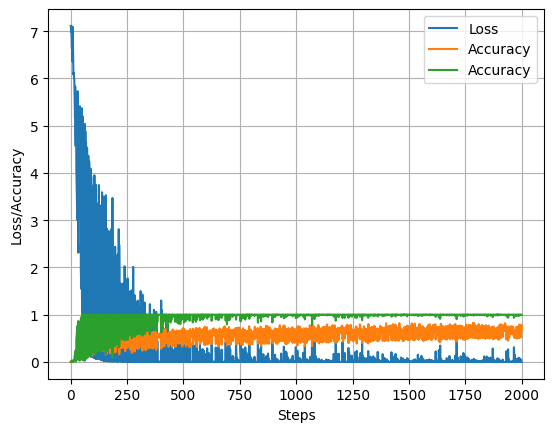

In [16]:
plt.plot(losses, label="Loss")
plt.plot(accuracies, label="Accuracy")
plt.grid(True)
plt.ylabel("Loss/Accuracy")
plt.xlabel("Steps")
plt.legend()
plt.show()

In [17]:
min(losses), max(accuracies), losses.index(min(losses)), accuracies.index(max(accuracies)) 

(2.4454382582916878e-05, (0.8233333230018616, 1.0), 1135, 1783)

# Test Generate

In [18]:
debug_input = next(train_iterator)
debug_input

({'qcode': tensor([[[ 696,  679, 1008,  ..., 1024, 1024, 1024],
           [ 923,  419,  866,  ..., 1024, 1024, 1024],
           [ 873,  949,  181,  ..., 1024, 1024, 1024],
           [ 330,  413,  639,  ..., 1024, 1024, 1024]],
  
          [[ 850,  642,  982,  ...,  239,  986,  226],
           [ 214,  993,  552,  ...,  827,  191,  858],
           [ 159,  159,   10,  ...,  405,  204,  318],
           [ 725,  567,  818,  ...,  257,  400,  819]]], device='cuda:0'),
  'mask': tensor([[[ True,  True,  True,  ..., False, False, False],
           [ True,  True,  True,  ..., False, False, False],
           [ True,  True,  True,  ..., False, False, False],
           [ True,  True,  True,  ..., False, False, False]],
  
          [[ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True],
           [ True,  True,  True,  ...,  True,  True,  True]]], device='cuda:0')},
 ['Thi

In [19]:
magnet_model.eval()
gen_tok = magnet_model.generate(
    prompt=debug_input[1],
    get_cond_tokens_func=preprocess_ops.tokenize,
    get_cond_tensors_func=preprocess_ops.get_conditioned_tensor,
    device=DEVICE,
    top_p=0.9,
    decoding_steps=[20, 10, 10, 10]
)
gen_tok.shape

torch.Size([2, 4, 750])

In [20]:
from src.utils.audio_utils import playAudio
gen_wav = preprocess_ops.getAudioFromCodings(gen_tok)
gen_wav.shape

torch.Size([2, 1, 240000])

In [21]:
playAudio(tensor=gen_wav[0].squeeze())

Playing WAVE '/tmp/tmpba2hfy2a.wav' : Float 32 bit Little Endian, Rate 16000 Hz, Mono


In [23]:
playAudio(tensor=gen_wav[1].squeeze())

Playing WAVE '/tmp/tmpjwue23vm.wav' : Float 32 bit Little Endian, Rate 16000 Hz, Mono
